<a href="https://colab.research.google.com/github/jairo-nlp/valuation/blob/master/Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!cp "drive/My Drive/analise.py" .
from analise import Analise

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [20]:
start = '2020-01-01'
end = '2020-07-30'

ativos = {
    'bancos': [
               'ITSA4.SA', 
               'BBDC4.SA', 
               'BBAS3.SA', 
               'SANB4.SA'
               ],
    'industrial': [
                   'WEGE3.SA', 
                   'TUPY3.SA', 
                   'MYPK3.SA', 
                   'SHUL4.SA'
                   ],
    'varejo': [
               'VVAR3.SA', 
               'BTOW3.SA', 
               'MGLU3.SA'
               ],
    'imobiliário': [
                    'TRIS3.SA', 
                    'ALSO3.SA', 
                    'MRVE3.SA', 
                    'EZTC3.SA', 
                    'TCSA3.SA',
                    'CYRE3.SA'],
    'saúde': [
              'AALR3.SA', 
              'FLRY3.SA', 
              'QUAL3.SA'
              ]
           }

In [21]:
analise_1 = Analise(ativos, start, end)

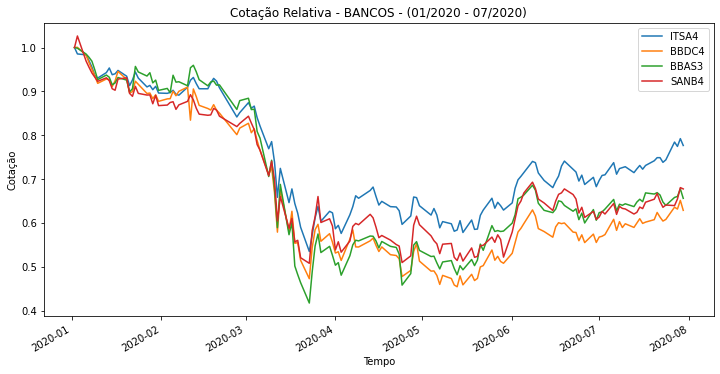

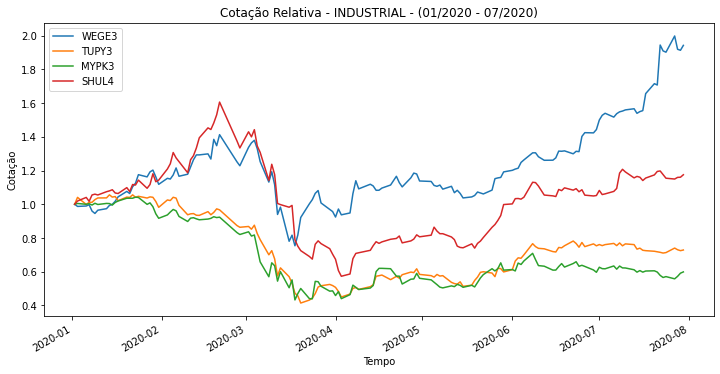

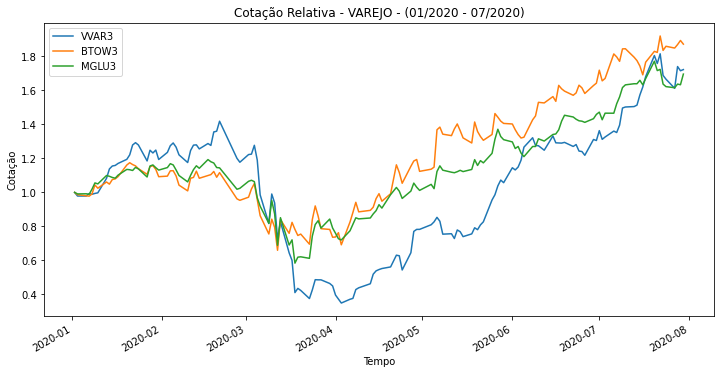

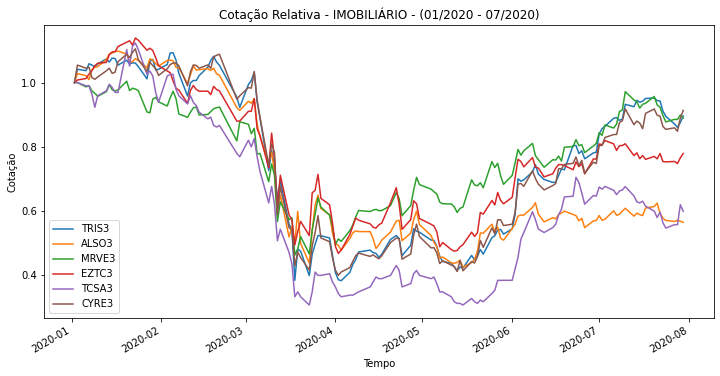

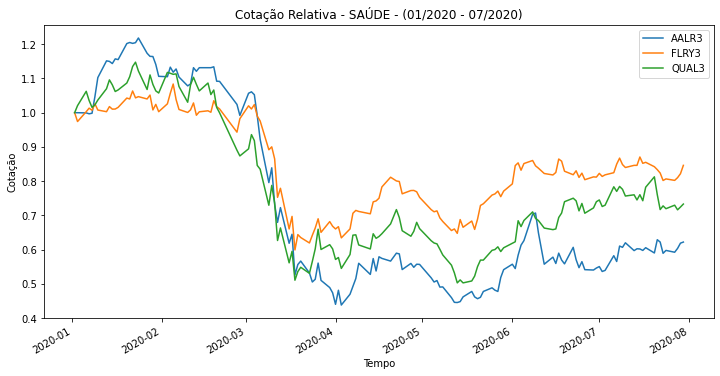

In [22]:
analise_1.analise_intrasetorial()

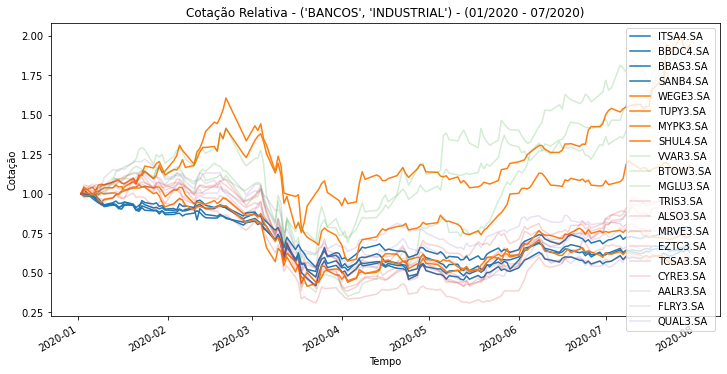

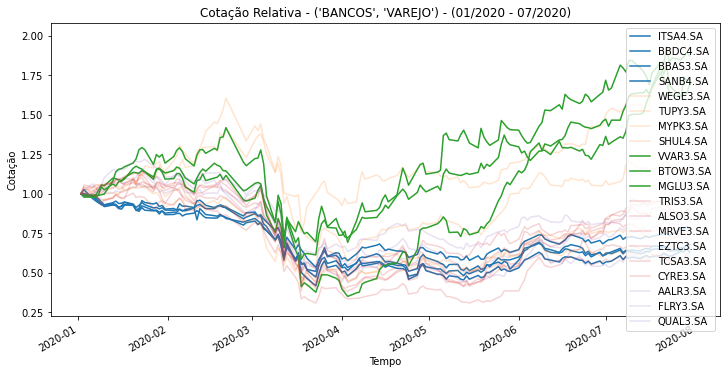

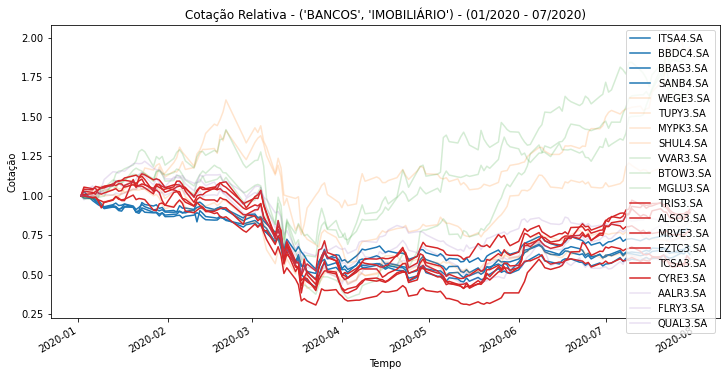

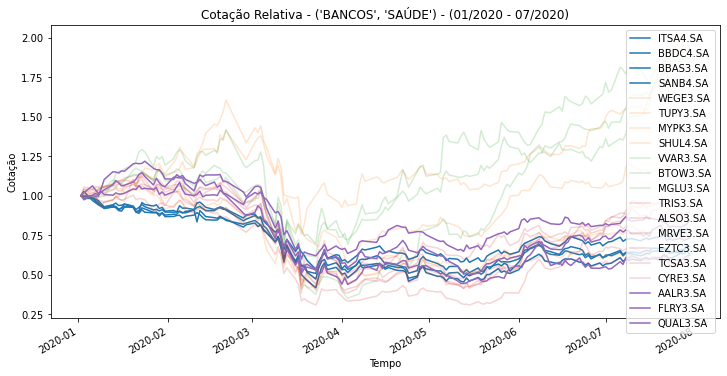

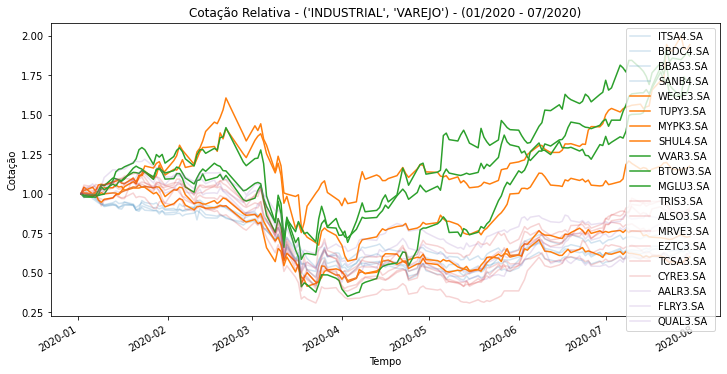

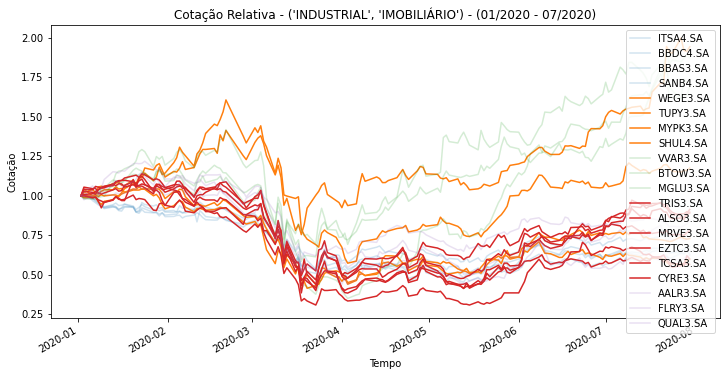

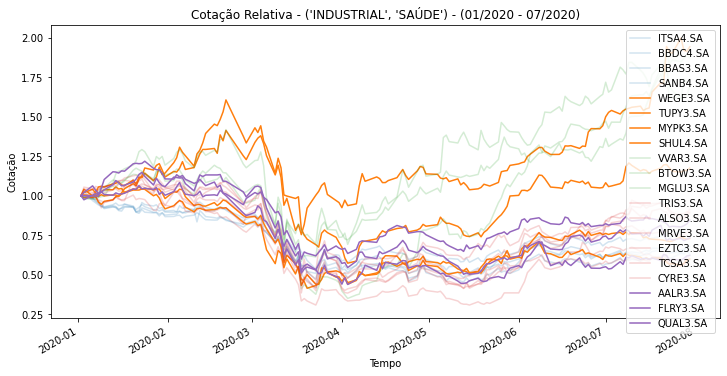

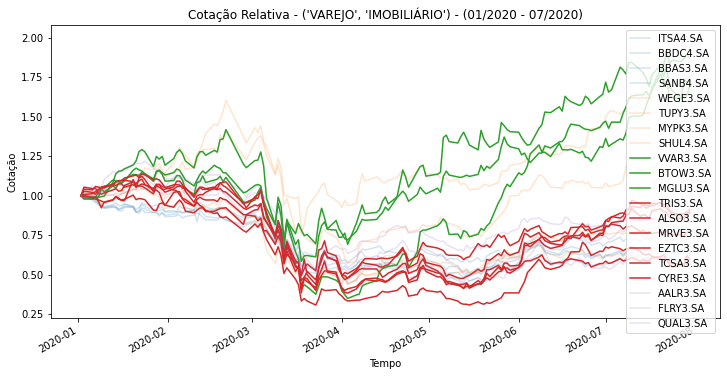

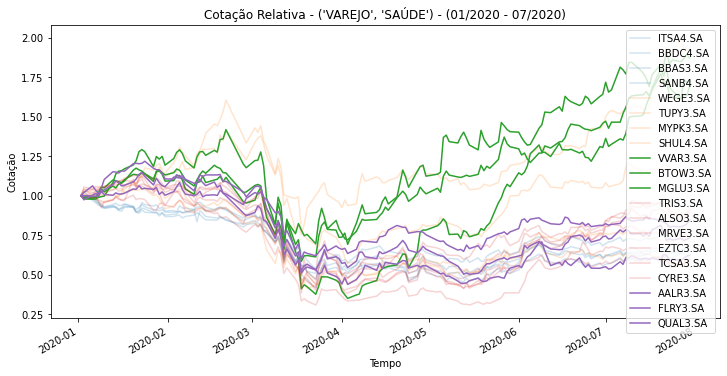

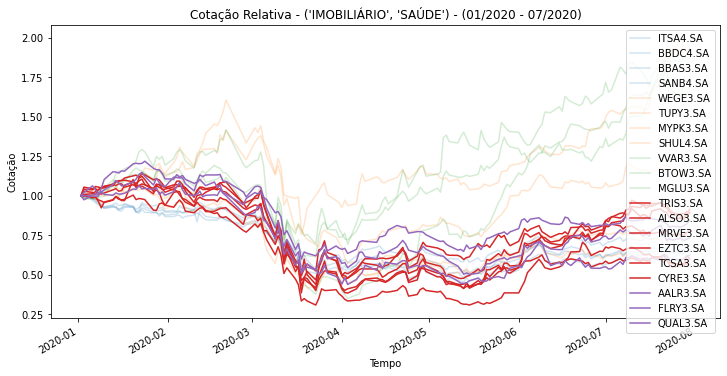

In [23]:
analise_1.analise_intersetorial()